#1 Import library


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import ndcg_score
import math
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2 Loading Data

In [ ]:
r_cols = ["UserID", "MovieID", "Rating", "Timestamp"]
raw_data = pd.read_csv("/content/drive/MyDrive/Colab/ML/ratings.dat", index_col = False ,delimiter="::",names = r_cols)

<ipython-input-114-ced61abebe18>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("/content/drive/MyDrive/Colab/ML/ratings.dat", index_col = False ,delimiter="::",names = r_cols)


## Change DataFrame into matrix numpy

In [ ]:
matrix_data = raw_data.to_numpy()


In [ ]:
# Index of movie and user-1
matrix_data[:,[0,1]] = matrix_data[:,[0,1]] - 1
matrix_data

array([[        0,      1192,         5, 978300760],
       [        0,       660,         3, 978302109],
       [        0,       913,         3, 978301968],
       ...,
       [     6039,       561,         5, 956704746],
       [     6039,      1095,         4, 956715648],
       [     6039,      1096,         4, 956715569]])

In [ ]:
# Splitting the data into training set and testing set
from sklearn.model_selection import train_test_split

rate_train, rate_test = train_test_split(matrix_data, test_size=0.1, stratify=matrix_data[:,0])
print(rate_train.shape, rate_test.shape)

(900188, 4) (100021, 4)


#3 Matrix Fatorization Using Gradient Descent Method

In [259]:
class GD(object):
  def __init__(self, data, nums_feature, lamda = 0.1, Xinit = None, Winit = None,
               learning_rate = 0.5, max_iter = 1000, print_every = 1000, user_based = 1):
    self.raw_data = data
    self.K = nums_feature

    # regularization term:
    self.lamda = lamda

    #Learning rate:
    self.alpha = learning_rate

    # Print result after print_every iterations
    self.print_every = print_every

    # number of user, items, ratings:
    self.n_users = int(np.max(self.raw_data[:,0]) + 1)
    self.n_items = int(np.max(self.raw_data[:,1]) + 1)
    self.n_objects = int(self.raw_data.shape[0])

    # Numbers of iterations:
    self.max_iter = max_iter

    # Choose the way to normalize data:
    self.user_based = user_based

    # Initialize X matrix and W matrix:
    if Xinit is not None:
      self.X = Xinit
    else:
      self.X = np.random.rand(self.n_items,self.K)

    if Winit is not None:
      self.W = Winit
    else:
      self.W = np.random.rand(self.K,self.n_users)

    # Make a copy of raw matrix to prepare for normalize:
    self.normal_matrix = self.raw_data.copy()

  def normalize(self):
      """
      We normalize the rating matrix:
      For each users, we calculate the mean of rating of movies that user vote for. Then subtract the rating with that mean value.
      """
      if self.user_based:
        user_col = 0
        item_col = 1
        n_objects = self.n_users
      else:
        user_col = 1
        item_col = 0
        n_objects = self.n_items

      # # Convert all value in rating matrix to integer value:
      self.normal_matrix = self.normal_matrix.astype("float32")

      # Create a array contain mean value for each object:
      self.mean = np.zeros((n_objects,))
      # Compute mean and subtract rating for each user:
      for n in range(n_objects):
        # find index row rating which rated by user n or rate for movie n (depend on user_based or item_based)
        ids = np.where(self.normal_matrix[:,user_col] == n)

        # Find the rating column
        rating = self.normal_matrix[ids,2]
        # Find the mean of rating column
        mean_value = np.mean(rating)
        # Check whether mean_value is none or not (since sometime rating column is empty -> mean_value = NULL)
        if np.isnan(mean_value):
          mean_value = 0
        self.mean[n] = mean_value
        # normalize:
        self.normal_matrix[ids,2] =  self.normal_matrix[ids,2] - mean_value

  def movie_rated_by_user(self, user):
    """
    Return idex and matrix of movie column rated by the user
    """
    # find index row of movies which are rated by user i
    idx = np.where(self.normal_matrix[:,0] == user)

    # list of movie id which are rated by user i
    movieId = self.raw_data[idx,1].reshape((np.size(idx),))

    return idx[0], self.X[movieId,:]


  def user_rate_for_movie(self, movie):
    """
    Return idex and matrix of user row who rate for the movie
    """
    # find index row of user who rate for movie i
    idx = np.where(self.normal_matrix[:,1] == movie)

    # list of user id who rate for movie i
    userId = self.raw_data[idx,0].reshape((np.size(idx),))

    return idx[0], self.W[:,userId]


  def loss(self):
        """
        Compute the loss
        """
        L = 0
        for i in range(self.n_objects):
            # user, item, rating
            n, m, rate = int(self.normal_matrix[i, 0]), int(self.normal_matrix[i, 1]), self.normal_matrix[i, 2]
            L += 0.5*(rate - self.X[m, :].dot(self.W[:, n]))**2

        # take average
        L /= self.n_objects
        # regularization term
        L += 0.5*self.lamda*(np.linalg.norm(self.X, 'fro') + np.linalg.norm(self.W, 'fro'))
        return L

  def update_X(self):
    for movie in range(self.n_items):
      # find index column of users which rate for movie i and
      # list of user id who rate for movie i
      idx,W = self.user_rate_for_movie(movie)
      actual_value = self.normal_matrix[idx,2]

      # Compute the predicted rating and error (1xn)
      predict = np.dot(self.X[movie,:], W)
      error = actual_value - predict
      # Update each row in X matrix
      self.X[movie,:] = self.X[movie,:] - self.alpha * ((-1/self.n_objects) * (np.dot(error, W.T)) + self.lamda * self.X[movie,:])

  def update_W(self):
    for user in range(self.n_users):
      # find index row of movie which is rated by user i
      # list of movie id which is rated by user i
      idx,X = self.movie_rated_by_user(user)

       # Compute the predicted rating row with shape (K,1) and error
      actual_value = self.normal_matrix[idx,2]
      predict  = np.dot(X, self.W[:,user])
      error = actual_value - predict
      # Update each column in W matrix
      self.W[:,user] = self.W[:,user] - self.alpha * ((-1/self.n_objects) * (np.dot(X.T,error)) + self.lamda * self.W[:,user])


  def print(self, itr):
    print("Iteration",itr, ": " + "loss: ",self.loss() ,"RMSE train : ", self.MSE(self.raw_data))

  def fit(self):
    self.normalize()
    for iter in range(self.max_iter):
      self.update_X()
      self.update_W()

      if (iter + 1) % self.print_every == 0:
        self.print(iter+1)

  def predict(self,user,movie):
    predict = np.dot(self.X[movie,:], self.W[:,user])
    if self.user_based:
        predict = predict + self.mean[user]
    else:
      predict = predict + self.mean[movie]
    if predict < 0:
      predict = 0
    elif predict > 5:
      predict = 5
    return predict

  def MSE(self, rate_test):
    MSE = 0
    MAE = 0
    n_tests = rate_test.shape[0]
    for i in range(n_tests):
      pred = self.predict(rate_test[i,0], rate_test[i,1])
      error = (rate_test[i,2] - pred)
      MAE += math.fabs(error)
      MSE += error**2
    MSE = math.sqrt(MSE/n_tests)
    MAE = MAE/n_tests
    return (MSE, MAE)

  def predict_matrix(self, rates):
    matrix=np.full((self.n_users,self.n_items),np.nan)
    for r in rates:
      matrix[r[0],r[1]] = self.predict(r[0],r[1])
    return matrix







In [260]:
def NDCG(mf,K):
    Y=mf.predict_matrix(rate_test)
    X=user_item_test.copy()
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    ndcg=[]
    for user in range(mf.n_users):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = rcm_movie[user][np.in1d(rcm_movie[user], rcm_test)]
        for i in range(len(rcm[:K])):
            dcg += (2**X[user][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**X[user][rcm_test[i]]-1)/math.log(i+2, 2)
        ndcg.append(dcg/idcg)
    return np.mean(ndcg)

In [261]:
def PrecisionAtK(mf,K):
    Y=mf.predict_matrix(rate_test)
    X=user_item_test.copy()
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    precisionK=[]
    recallK=[]
    f1K=[]
    mapK=[]
    for user in range(mf.n_users):
        rcm = rcm_movie[user]
        rcm = rcm[np.argwhere(Y[user][rcm] > mf.mean[user])]
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = np.intersect1d(rcm, rcm_test)
        rcm_test = rcm_test[np.argwhere(X[user][rcm_test] > mf.mean[user])]
        rcm = rcm[:K]

        precision=np.in1d(rcm,rcm_test)
        recall=np.in1d(rcm_test,rcm)

        map=[]
        for k in range(len(rcm)):
            p = np.mean(precision[:k+1])*precision[k]
            if p>0:
                map.append(p)

        precision=np.mean(precision)
        recall=np.mean(recall)
        f1=0
        if precision + recall != 0:
            f1 = 2*precision*recall/(precision+recall)
        precisionK.append(precision)
        recallK.append(recall)
        f1K.append(f1)
        mapK.append(np.mean(map))

    precisionK=np.nan_to_num(precisionK)
    recallK=np.nan_to_num(recallK)
    f1K=np.nan_to_num(f1K)
    mapK=np.nan_to_num(mapK)

    return (np.mean(precisionK), np.mean(recallK), np.mean(f1K), np.mean(mapK))

In [222]:
user_item_test=np.full((6040,3952),np.nan)
for r in rate_test:
    user_item_test[r[0], r[1]]=r[2]

# 4. Matrix Factorization Using Singular Value Decomposition

In [306]:
class SVD(object):
  def __init__(self, data, rank, user_based = 1):
    self.raw_data = data
    self.rank = rank

    # number of user, items, ratings:
    self.n_users = int(np.max(self.raw_data[:,0]) + 1)
    self.n_items = int(np.max(self.raw_data[:,1]) + 1)
    self.n_objects = int(self.raw_data.shape[0])

    # Choose the way to normalize data:
    self.user_based = user_based

    # Make a copy of raw matrix to prepare for normalize:
    self.normal_matrix = self.raw_data.copy()

  def normalize(self):
      """
      We normalize the rating matrix:
      For each users, we calculate the mean of rating of movies that user vote for. Then subtract the rating with that mean value.
      """
      if self.user_based:
        user_col = 0
        item_col = 1
        n_objects = self.n_users
      else:
        user_col = 1
        item_col = 0
        n_objects = self.n_items

      # # Convert all value in rating matrix to integer value:
      self.normal_matrix = self.normal_matrix.astype("float32")

      # Create a array contain mean value for each object:
      self.mean = np.zeros((n_objects,))
      # Compute mean and subtract rating for each user:
      for n in range(n_objects):
        # find index row rating which rated by user n or rate for movie n (depend on user_based or item_based)
        ids = np.where(self.normal_matrix[:,user_col] == n)

        # Find the rating column
        rating = self.normal_matrix[ids,2]
        # Find the mean of rating column
        mean_value = np.mean(rating)
        # Check whether mean_value is none or not (since sometime rating column is empty -> mean_value = NULL)
        if np.isnan(mean_value):
          mean_value = 0
        self.mean[n] = mean_value
        # normalize:
        self.normal_matrix[ids,2] =  self.normal_matrix[ids,2] - mean_value

        # Change the normal_matrix into sparse normal matrix:
      self.normal_matrix = sparse.coo_matrix((self.normal_matrix[:, 2],
          (self.normal_matrix[:, 1], self.normal_matrix[:, 0])), (self.n_items, self.n_users))
      self.normal_matrix = self.normal_matrix.todense()


  def SVD(self):
    self.normalize()
    # Singular value decomposition:
    U,S,V_T = np.linalg.svd(self.normal_matrix, full_matrices = False)
    # left singular vector
    Uk = U[:,:self.rank]
    # singular matrix
    self.S = S
    S = np.diag(S)
    Sk = S[:self.rank,:self.rank]
    # Right singular vector:
    V_Tk = V_T[:self.rank, :]

    # Approximation matrix:
    self.res = Uk @ Sk @ V_Tk

  def plot_singular(self):
    plt.semilogy(np.diag(self.S))
    plt.title('Singular values')
    plt.show()


  def predict(self,user,movie):
    predict = self.res[movie,user]
    if self.user_based:
        predict = predict + self.mean[user]
    else:
      predict = predict + self.mean[movie]
    if predict < 0:
      predict = 0
    elif predict > 5:
      predict = 5
    return predict

  def sort_predict_test_dataset(self, rate_test):
    n_tests = rate_test.shape[0]
    PredictDict = dict()
    for i in range(n_tests):
      movie = int(rate_test[i,1])
      user = int(rate_test[i,0])
      predict = self.predict(user,movie)
      PredictDict[i] = predict

    # Sort:
    sortPredict = dict(sorted(PredictDict.items(), key = lambda x: x[1], reverse = True))

    # change to binary:
    for key in sortPredict.keys():
      if (sortPredict[key] >= self.mean[rate_test[key,0]]):
        sortPredict[key] = 1
      else:
        sortPredict[key] = 0
    return sortPredict

  def predict_test_dataset(self, rate_test):
    n_tests = rate_test.shape[0]
    PredictDict = dict()
    for i in range(n_tests):
      movie = int(rate_test[i,1])
      user = int(rate_test[i,0])
      predict = self.predict(user,movie)
      PredictDict[i] = predict

    # change to binary:
    for key in PredictDict.keys():
      if (PredictDict[key] >= self.mean[rate_test[key,0]]):
        PredictDict[key] = 1
      else:
        PredictDict[key] = 0
    return PredictDict

  def predict_eachUser(self,rate_test,sort):
    predictDict = dict()
    n_users = np.max(rate_test[:,0]) + 1
    for u in range(n_users):
      idxDict = dict()
      idx = np.where(rate_test[:,0] == u)[0]
      for i in idx:
        idxDict[i] = self.predict(rate_test[i,0], rate_test[i,1])
      if (sort == 1):
        idxDict = dict(sorted(idxDict.items(), key = lambda x : x[1], reverse = True))
      ratings = [1 if r > self.mean[u] else 0 for r in idxDict.values()]
      predictDict[u] = [ratings,list(idxDict.keys())]
    return predictDict





  def MSE(self, rate_test):
    RMSE = 0
    MAE = 0
    n_tests = rate_test.shape[0]
    for i in range(n_tests):
      pred = self.predict(rate_test[i,0], rate_test[i,1])
      error = (rate_test[i,2] - pred)
      MAE += math.fabs(error)
      RMSE += error**2
    RMSE = math.sqrt(RMSE/n_tests)
    MAE = MAE/n_tests
    return RMSE,MAE

In [296]:
def PrecisionAtK(mf,K):
    Y=np.array(mf.res.T)
    X=user_item_test.copy()
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    precisionK=[]
    recallK=[]
    f1K=[]
    mapK=[]
    for user in range(mf.n_users):
        rcm = rcm_movie[user]
        rcm = rcm[np.argwhere(Y[user][rcm] > 0)]
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = np.intersect1d(rcm, rcm_test)
        rcm_test = rcm_test[np.argwhere(X[user][rcm_test] > mf.mean[user])]
        rcm = rcm[:K]

        precision=np.in1d(rcm,rcm_test)
        recall=np.in1d(rcm_test,rcm)

        map=[]
        for k in range(len(rcm)):
            p = np.mean(precision[:k+1])*precision[k]
            if p>0:
                map.append(p)

        precision=np.mean(precision)
        recall=np.mean(recall)
        f1=0
        if precision + recall != 0:
            f1 = 2*precision*recall/(precision+recall)
        precisionK.append(precision)
        recallK.append(recall)
        f1K.append(f1)
        mapK.append(np.mean(map))

    precisionK=np.nan_to_num(precisionK)
    recallK=np.nan_to_num(recallK)
    f1K=np.nan_to_num(f1K)
    mapK=np.nan_to_num(mapK)

    return (np.mean(precisionK), np.mean(recallK), np.mean(f1K), np.mean(mapK))

In [299]:
def NDCG(mf,K):
    Y=np.array(mf.res.T)
    X=user_item_test.copy()
    rcm_movie_test = np.argsort(-(X))
    rcm_movie = np.argsort(-Y)
    ndcg=[]
    for user in range(mf.n_users):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[user][np.in1d(rcm_movie_test[user], np.argwhere(~np.isnan(X[user])))]
        rcm = rcm_movie[user][np.in1d(rcm_movie[user], rcm_test)]
        for i in range(len(rcm[:K])):
            dcg += (2**X[user][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**X[user][rcm_test[i]]-1)/math.log(i+2, 2)
        ndcg.append(dcg/idcg)
    return np.mean(ndcg)

#5 Visualize the accuracy of model

## With each value of iteration for MFGD


In [230]:
iteration_list = [1,5,10,15,30,40]
MAE = []
RMSE = []
Precision = []
Recall = []
F1 = []
MAP = []
ndcg = []

In [231]:
for iter in iteration_list:
  mf = GD(rate_train, nums_feature = 10, lamda = 0.1, learning_rate = 0.5,max_iter = iter, print_every = 10,user_based = 1)
  mf.fit()
  se=mf.MSE(rate_test)
  RMSE.append(se[0])
  MAE.append(se[1])
  metric = PrecisionAtK(mf, 10000)
  Precision.append(metric[0])
  Recall.append(metric[1])
  F1.append(metric[2])
  MAP.append(metric[3])
  ndcg.append(NDCG(mf, 10000))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration 10 : loss:  8.632003613878938 RMSE train :  (1.3604199325226032, 1.0529190364024508)
Iteration 10 : loss:  8.612438842472514 RMSE train :  (1.3550057004628415, 1.0477648164853175)
Iteration 10 : loss:  8.634427045822438 RMSE train :  (1.3600993831821806, 1.0526027832392346)
Iteration 20 : loss:  5.178118551292689 RMSE train :  (1.080257727658181, 0.8411441041240001)
Iteration 30 : loss:  3.2860217808344263 RMSE train :  (1.0349536332336218, 0.8186430143753756)
Iteration 10 : loss:  8.642902901931484 RMSE train :  (1.3575505370101995, 1.050504154889444)
Iteration 20 : loss:  5.184245466845274 RMSE train :  (1.0804166605143368, 0.841571523755104)
Iteration 30 : loss:  3.2897381935382093 RMSE train :  (1.0350955775511212, 0.818858186194005)
Iteration 40 : loss:  2.17822830342412 RMSE train :  (1.0289762233493274, 0.8202214206396097)


In [ ]:
from importlib import reload
print('RMSE: ', RMSE)
print('MAE: ', MAE)
plt=reload(plt)
plt.title('RMSE & MAE')
plt.plot(iteration_list,RMSE, label='RMSE')
plt.plot(iteration_list, MAE, label='MAE')
plt.xlabel("Iteration")
plt.legend()
plt.show()

In [ ]:
plt=reload(plt)
plt.title('Precision & Recall')
plt.plot(iteration_list,Precision)
plt.plot(iteration_list,Recall)
plt.plot(iteration_list,F1)
plt.xlabel("Iteration")
plt.show()

In [ ]:
plt=reload(plt)
plt.title('NDCG')
plt.plot(iteration_list,ndcg)
plt.xlabel("Iteration")
plt.show()

# Number of movie GD

In [150]:
g = GD(rate_train, nums_feature = 10, lamda = 0.1, learning_rate = 0.5,max_iter = 30, print_every = 30,user_based = 1)
g.fit()

Iteration 30 : loss:  3.2818765059164554 RMSE train :  (1.0343343282589292, 0.8178753554208529)


In [224]:
precision = []
recall = []
f1 = []
ndcg = []
map=[]
num_movie = [5,15,30,50,100]
for k in num_movie:
    metric=PrecisionAtK(g, k)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])
    map.append(metric[3])

    ndcg.append(NDCG(g, k))

Precision:  [0.5533333333333333, 0.5466050643616868, 0.5442202938035032, 0.5425070242216276, 0.542119713287286]


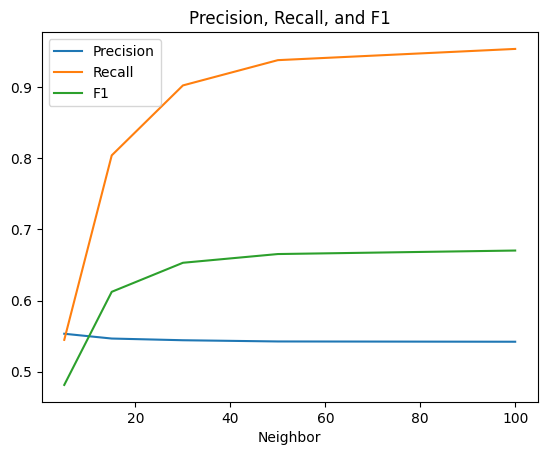

In [229]:
print("Precision: ",precision)
print('Recall: ', recall)
print('F1: ', f1)
plt=reload(plt)
plt.plot(num_movie, precision,label='Precision')
plt.plot(num_movie, recall, label='Recall')
plt.plot(num_movie, f1, label='F1')
plt.xlabel('Neighbor')
plt.title('Precision, Recall, and F1')
plt.legend()
plt.show()

MAP:  [0.6911334161147903, 0.6631326308781873, 0.6571741125714976, 0.6560504802626287, 0.6556311910213404]
NDCG:  [0.6985501608715777, 0.7864543088444106, 0.8245050211416255, 0.839666443049453, 0.8466278572389989]


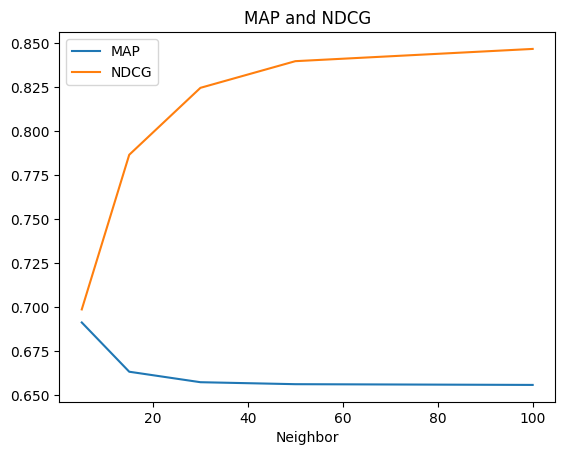

In [228]:
print("MAP: ",map)
print('NDCG: ', ndcg)
plt=reload(plt)
plt.plot(num_movie, map, label='MAP')
plt.plot(num_movie, ndcg, label ='NDCG')
plt.xlabel('Neighbor')
plt.title('MAP and NDCG')
plt.legend()
plt.show()

# Rank list for SVD

In [307]:
rank_list = [1,5,10,15,20,30,40,50,100]
RMSE = []
MAE = []
Precision = []
Recall = []
F1 =[]
MAP = []
ndcg = []

In [308]:
for rank in rank_list:
  svd = SVD(rate_train, rank)
  svd.SVD()

  e=svd.MSE(rate_test)
  RMSE.append(e[0])
  MAE.append(e[1])

  metric = PrecisionAtK(svd, 10000)
  Precision.append(metric[0])
  Recall.append(metric[1])
  F1.append(metric[2])
  MAP.append(metric[3])

  ndcg.append(NDCG(svd, 10000))

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RMSE:  [0.9914716595662433, 0.9686129428734775, 0.9575913712996746, 0.952570081500044, 0.9502424625100652, 0.9494636687459359, 0.9508973048744814, 0.9531254220219714, 0.9650177083769557]
MAE:  [0.7883899487433401, 0.7670677175431638, 0.7570853066168888, 0.7526140690914911, 0.7505897221756591, 0.7498679986606254, 0.7511601539311157, 0.7529686362437356, 0.7636768585233183]


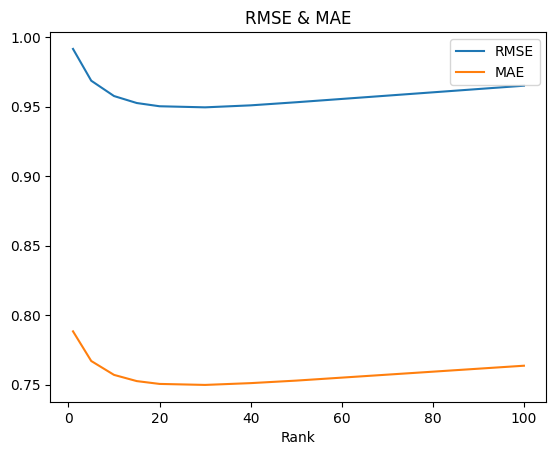

In [321]:
from importlib import reload
print('RMSE: ', RMSE)
print('MAE: ', MAE)
plt=reload(plt)
plt.title('RMSE & MAE')
plt.plot(rank_list,RMSE, label='RMSE')
plt.plot(rank_list, MAE, label='MAE')
plt.xlabel("Rank")
plt.legend()
plt.show()

Precision:  [0.6228964425780302, 0.649124410702186, 0.647637364896268, 0.6492594119054297, 0.6476567006034549, 0.6498352602345646, 0.6449564693125629, 0.6407096664054623, 0.6310946719263374]
Recall:,  [0.7263939321920929, 0.7297888873279939, 0.727176186366071, 0.7220583487612242, 0.7091687585205113, 0.6999943490593697, 0.6890644280396975, 0.6819107442358644, 0.6560865780466119]
F1:  [0.6366485878199568, 0.6579324533913827, 0.6565966668637434, 0.6547946984080959, 0.6482957668080841, 0.6453359793028208, 0.6378117930152121, 0.632350815490198, 0.615475738561116]


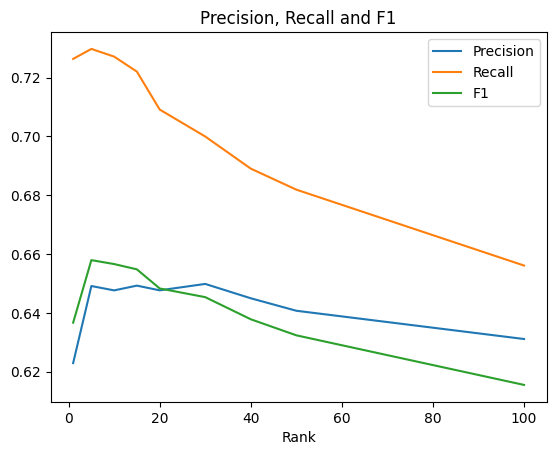

In [318]:
from importlib import reload
print('Precision: ', Precision)
print('Recall:, ', Recall)
print('F1: ', F1)
plt=reload(plt)
plt.title('Precision, Recall and F1')
plt.plot(rank_list,Precision, label='Precision')
plt.plot(rank_list, Recall, label='Recall')
plt.plot(rank_list, F1, label='F1')
plt.xlabel("Rank")
plt.legend()
plt.show()

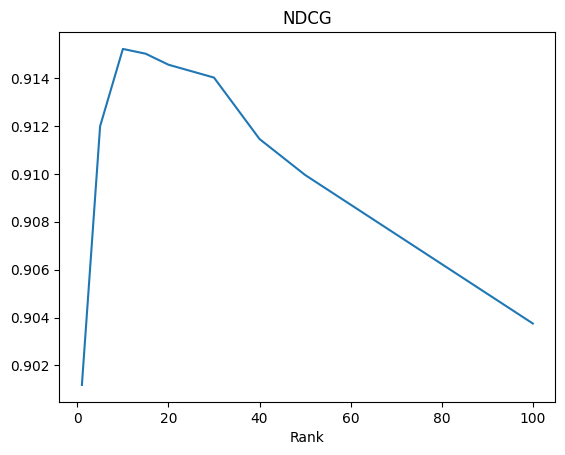

In [315]:
plt=reload(plt)
plt.title('NDCG')
plt.plot(rank_list,ndcg)
plt.xlabel("Rank")
plt.show()

# Number of movie for SVD

In [322]:
svd = SVD(rate_train, 10)
svd.SVD()

In [331]:
num_movie = [5, 15, 30, 50, 100]
RMSE = []
MAP = []
Precision = []
Recall = []
F1 =[]
MAP = []
ndcg = []

In [332]:
for num in num_movie:

  metric = PrecisionAtK(svd, num)
  Precision.append(metric[0])
  Recall.append(metric[1])
  F1.append(metric[2])
  MAP.append(metric[3])

  ndcg.append(NDCG(svd, num))

Precision:  [0.6551683222958057, 0.6502164502164501, 0.6478822368921359, 0.6477375301791765, 0.6476366488255066]
Recall:,  [0.4987229618932004, 0.6731882918869069, 0.7163975070355264, 0.7259708213522811, 0.7271427071521283]
F1:  [0.5079643769556142, 0.6248394487981405, 0.6505737210222736, 0.6559772360929369, 0.6565823154463168]


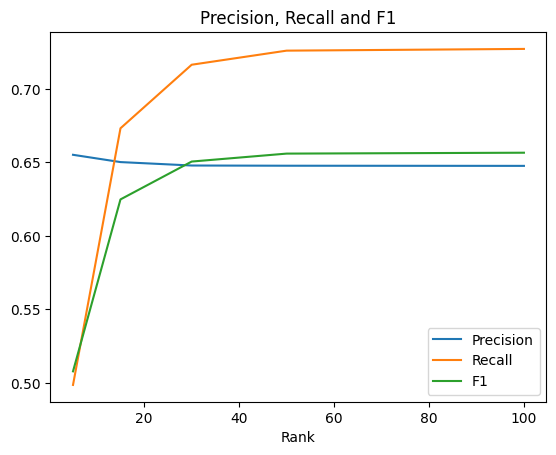

In [333]:
from importlib import reload
print('Precision: ', Precision)
print('Recall:, ', Recall)
print('F1: ', F1)
plt=reload(plt)
plt.title('Precision, Recall and F1')
plt.plot(num_movie,Precision, label='Precision')
plt.plot(num_movie, Recall, label='Recall')
plt.plot(num_movie, F1, label='F1')
plt.xlabel("Number of movie")
plt.legend()
plt.show()

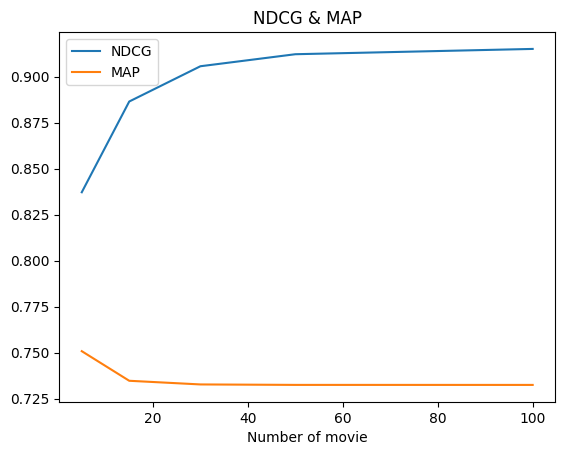

In [338]:
plt=reload(plt)
plt.title('NDCG & MAP')
plt.plot(num_movie,ndcg, label='NDCG')
plt.plot(num_movie,MAP, label='MAP')
plt.xlabel("Number of movie")
plt.legend()
plt.show()